In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory

import os
import dill
%load_ext autoreload


#os.listdir()

Using TensorFlow backend.


In [2]:
from Distillation_simple1 import simulator

In [3]:
env = simulator()
nb_actions = env.action_space.n
env.observation_space, env.action_space

(Box(6,), Discrete(5))

In [4]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(nb_actions, activation = 'linear'))
print(model.summary())

W0925 16:09:28.008850 12468 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0925 16:09:28.032822 12468 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0925 16:09:28.044825 12468 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                112       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 85        
Total params: 741
Trainable params: 741
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
steps = 2e5
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test= 0, nb_steps=steps)
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, enable_double_dqn = True,  
               enable_dueling_network = True, nb_steps_warmup=9, target_model_update=1e-2, policy=policy, delta_clip = 1)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [12]:
hist = dqn.fit(env, nb_steps=steps)

Training for 200000.0 steps ...
Interval 1 (0 steps performed)
   42/10000 [..............................] - ETA: 5:59 - reward: -392.4829

C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\rl\memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
D:\Github\RL-Process-Design\Distillation\Distillation_simple1.py:50: RuntimeWarning: invalid value encountered in double_scalars
  LK_B = bots[action]/sum(bots)
D:\Github\RL-Process-Design\Distillation\Distillation_simple1.py:49: RuntimeWarning: invalid value encountered in double_scalars
  LK_D = tops[action]/sum(tops)


10000/10000 [==============================] - 45s 4ms/step - reward: -321.2588
2476 episodes - episode_reward: -1297.489 [-7075.053, 964.077] - loss: 40.118 - mean_absolute_error: 582.800 - mean_q: 739.746 - mean_eps: 0.977

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 55s 5ms/step - reward: -311.6878
2431 episodes - episode_reward: -1282.136 [-6042.059, 968.249] - loss: 12.658 - mean_absolute_error: 666.084 - mean_q: 915.162 - mean_eps: 0.933

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 55s 5ms/step - reward: -312.0030
2412 episodes - episode_reward: -1293.550 [-7031.215, 968.249] - loss: 12.983 - mean_absolute_error: 664.959 - mean_q: 914.225 - mean_eps: 0.888

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 52s 5ms/step - reward: -289.1528
2440 episodes - episode_reward: -1185.050 [-6048.357, 968.249] - loss: 13.483 - mean_absolute_error: 663.719 - mean_q: 912.682 - mean_eps

In [13]:
print(hist.history.keys())

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


In [14]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

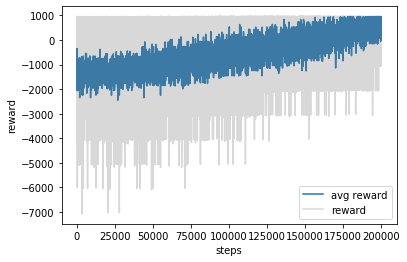

In [15]:
smoothed_rews = running_mean(hist.history['episode_reward'], 10)
plt.plot(hist.history['nb_steps'][-len(smoothed_rews):], smoothed_rews)
plt.plot(hist.history['nb_steps'],hist.history['episode_reward'],color='grey', alpha=0.3)
plt.xlabel("steps")
plt.ylabel("reward")
plt.legend(["avg reward", "reward"])

In [16]:
dqn.test(env, visualize = True)

Testing for 1 episodes ...
total cost: 31.582638701433314 sep_order = [1]
total cost: 38.9294406294686 sep_order = [1, 0]
total cost: 42.327224237484316 sep_order = [1, 0, 4]
total cost: 51.58497513626267 sep_order = [1, 0, 4, 2]
total cost: 95.39453756297965 sep_order = [1, 0, 4, 2, 3]
Episode 1: reward: 948.415, steps: 5
